In [1]:
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')

In [2]:
from edamame import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import pickle 
import _pickle as cPickle
import gzip
from IPython.core.debugger import set_trace


In [3]:
def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)
def decompress_pickle(file):
    with gzip.open(file, 'rb') as f:
        loaded_object = cPickle.load(f,encoding="bytes") #change this for python 2
        return loaded_object

In [4]:
name='/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/300nw_4_modules_10sets_NWN.pkl'
print('Loading NWN Networks, MC and NLT Results')
file = open(name, 'rb')
[Modular] = pickle.load(file)

Loading NWN Networks, MC and NLT Results


In [5]:
onAmp=[0.2,0.5,0.75,1,1.25,1.5,1.75,2,3,5,10]

In [6]:
dataLoc='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/ModularNWNs/VSweep/'

In [7]:
#save networks separately so Dask can run it more efficiently
count = 1
for i in tqdm(range(len(Modular))):
    for j in range(len(Modular[i])):
        n=connectivity__(wires_dict=Modular[i][j])
        compressed_pickle(n,dataLoc+'/NWN_Network_4modules_10sets_'+str(count)+'.pkl')
        count = count+1

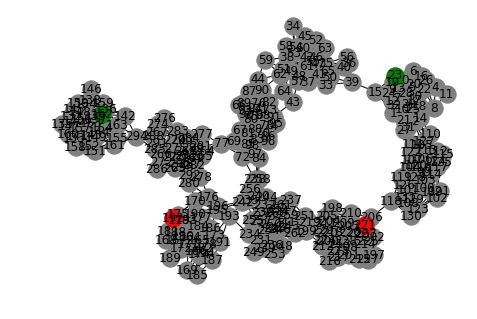

In [126]:
nw=8
mod=5
pos=nx.kamada_kawai_layout(nx.from_numpy_array(Modular[nw][mod]['adj_matrix']))
nx.draw(nx.from_numpy_array(Modular[nw][mod]['adj_matrix']),pos=pos,node_color='grey',with_labels=True)
nx.draw_networkx_nodes(nx.from_numpy_array(Modular[nw][mod]['adj_matrix']),pos=pos,nodelist=[23,162],node_color='g')
nx.draw_networkx_nodes(nx.from_numpy_array(Modular[nw][mod]['adj_matrix']),pos=pos,nodelist=[192,221],node_color='r')

In [77]:
def voltSweep(onAmp,i,j):
    ampName=str(onAmp).replace('.','p')
#     Graph=decompress_pickle(r'/project/NASN/Alon/BA/BA Networks/BA_Network_'+str(j+1)+'.pkl')
#     Graph=decompress_pickle(r'/project/NASN/Alon//HNW/HNW Networks/HNW_Network_'+str(j+1)+'.pkl')
#     Network=decompress_pickle(r'/project/NASN/Alon/BetaSweep/BetaSweep Networks/BetaSweep_Network_'+str(j+1)+'_'+str(k+1)+'_'+str(m+1)+'.pkl')
#     Connectivity=decompress_pickle(r'/project/NASN/Alon/NWN/NWN Networks/NWN_Network_9modules_100sets_'+str(j+1)+'.pkl')
    Connectivity=decompress_pickle(dataLoc+'NWN_Network_9modules_10sets_'+str(j+1)+'.pkl')

    Graph= nx.from_numpy_matrix(Connectivity.adj_matrix)
    #     Graph=Network['G']
#     del Network
    #for each network
    stimulus=[]
    dt = 1e-3
    f=0.5
    Time=5

    #Choose Electrode Pattern

    stimulus.append((stimulus__(biasType='AC',onAmp=onAmp,TimeVector=np.arange(0,Time,dt),f=f)))
    stimulus.append((stimulus__(biasType='AC',onAmp=onAmp,TimeVector=np.arange(0,Time,dt),f=f)))
    stimulus.append((stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt)))) #we don't want this drain to be active during training
    stimulus.append((stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt)))) #we don't want this drain to be active during training

    #choose electrode locations:
    elecs=[23,162,192,221]
    #Initialise Output Variables
    period=[]
    TimeVector=[]
    voltage=[]
    conductance=[]
    switches=[]
#     set_trace()
#     stimulus2 = [item for item in stimulus] #go through each list in the list and find the ith item

#     results_minMax=runSim(Connectivity ,stimulus=stimulus2, contactMode='farthest', T = Time, dt = dt, onAmp = onAmp, biasType='AC',f=f,junctionMode='tunneling')
    results_minMax=runSim(connectivity__(graph=Graph),stimulus=stimulus, contactMode='preSet', electrodes=elecs,T = Time, dt = dt, onAmp = onAmp, biasType='AC',f=f,junctionMode='tunneling',findFirst=False)
#     set_trace()
    print('saving')
    activation = findCurrent(results_minMax, 1)
    results={'JunctionConductance':results_minMax.junctionConductance[-1],'JunctionVoltage':results_minMax.junctionVoltage[-1],'Switch':results_minMax.junctionSwitch[-1],'Source':results_minMax.sources[0:2],'Drain':results_minMax.drains[0:2],'Signal':results_minMax.stimulus,'CurrentPath':activation}
    compressed_pickle(results,dataLoc+'_NLT_Simulation_'+'_9modules_10sets_Network_'+str(j+1)+'_'+ampName+'v.pkl')
        #     compressed_pickle(results,r'/project/NASN/Alon/'+nwType+'/'+nwType+' Results/'+nwType+'_NLT_Simulation_'+'Density_Network_'+str(j+1)+'_'+ampName+'v.pkl')
    results_minMax.frequency=f
    results_minMax.dt=dt
    period=1/f

    if len(Graph) >= 250:
#         nodesList=[50,100,150,200,250,len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G'])]#range(50, len(ws300[i][0])+1,50)
        nodesList=[len(Graph)]#only want all nodes
    elif len(Graph) >= 200 and len(Graph) < 250:
        nodesList=[len(Graph)]
    elif len(Graph) >= 150 and len(Graph) < 200:
        nodesList=[len(Graph)] 
    elif len(Graph) >= 100 and len(Graph) < 150:
        nodesList=[len(Graph)]

    nwSqu =[None]*len(nodesList)

    countK=0
    for k in nodesList: #loop through sets of nodes for regression
        print('Running Regression: ' + str(k) + ' nodes')
        ResultSqu=[]
        ResultSqu = nonLinearTrans(results_minMax,'Square',k, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)
        nwSqu[countK]=ResultSqu['accuracy']
        countK=countK+1
        
    return nwSqu


In [78]:
init=[]
for i in tqdm(range(len(onAmp))): #for each voltage
    for j in range(60): #for each network
        init.append(inputPacker(voltSweep,onAmp[i],i,j))

In [79]:
result=para_run(voltSweep,init,nCPU=10,start_method='fork')

saving
Unfortunately, only 0 current paths found in simulation time.
saving
Running Regression: 295 nodes
saving
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes


saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
saving
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
Unfortunately, only 0 current paths found in simulation time.
Unfortunately, only 0 current paths found in simulation time.Running Regression: 295 nodes

Running Regression: 295 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
savingsaving

Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes


saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes


saving
saving
saving
Unfortunately, only 0 current paths found in simulation time.
saving
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes


saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes


saving
saving
Unfortunately, only 0 current paths found in simulation time.
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
Running Regression: 296 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
savingsaving

saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes


saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes


saving
saving
Unfortunately, only 0 current paths found in simulation time.
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
Running Regression: 295 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
Unfortunately, only 0 current paths found in simulation time.
saving
Running Regression: 295 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes


saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes


saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
saving
Unfortunately, only 0 current paths found in simulation time.
saving
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes


saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes


saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes


saving
saving
Running Regression: 297 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.saving

Running Regression: 295 nodes
Running Regression: 295 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
Running Regression: 295 nodes


saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.Unfortunately, only 0 current paths found in simulation time.

Running Regression: 295 nodes
Running Regression: 295 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
Running Regression: 296 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
saving
Running Regression: 296 nodes
Running Regression: 296 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes


saving
saving
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
saving
Running Regression: 296 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
saving
saving
Running Regression: 297 nodes
Running Regression: 297 nodes
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes


saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
Running Regression: 296 nodesRunning Regression: 296 nodes

saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes


saving
saving
Running Regression: 297 nodes
savingUnfortunately, only 0 current paths found in simulation time.

Running Regression: 297 nodes
saving
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
saving
Running Regression: 297 nodes
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


savingsaving

Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
saving
saving
saving
Unfortunately, only 0 current paths found in simulation time.
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Running Regression: 297 nodesRunning Regression: 297 nodesRunning Regression: 297 nodes


Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
saving
Running Regression: 297 nodes
Running Regression: 297 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes


saving
Running Regression: 295 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
saving
saving
Running Regression: 295 nodes
Running Regression: 295 nodes
Running Regression: 295 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 295 nodes
saving
saving


Running Regression: 297 nodes
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 296 nodes
saving
saving
Running Regression: 296 nodes
Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
saving
Running Regression: 296 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes


savingsaving

Running Regression: 297 nodes
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
saving
Running Regression: 297 nodes


saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes


saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
saving
Running Regression: 296 nodes
Unfortunately, only 0 current paths found in simulation time.
Running Regression: 296 nodes
saving
saving
Running Regression: 297 nodes
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes


saving
saving


Unfortunately, only 0 current paths found in simulation time.
Running Regression: 297 nodes
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 295 nodes


saving
Running Regression: 295 nodes
saving
saving
Running Regression: 295 nodesRunning Regression: 295 nodes



saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
saving
Running Regression: 295 nodes
Running Regression: 295 nodes


saving
Running Regression: 295 nodes


saving
Running Regression: 295 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes


saving
saving
Running Regression: 297 nodes
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
saving
Running Regression: 297 nodes
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
saving


Running Regression: 297 nodes
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving


Running Regression: 297 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes


saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes


saving
Running Regression: 295 nodes


saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes


saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes


saving
saving
Running Regression: 297 nodes
Running Regression: 297 nodes


saving
saving
Running Regression: 297 nodes
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
Running Regression: 296 nodes
saving


Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
Running Regression: 296 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
saving
Running Regression: 297 nodes
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
saving
Running Regression: 296 nodes
Running Regression: 296 nodes


saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
saving
Running Regression: 297 nodes
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 295 nodes


saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes


saving
saving
Running Regression: 295 nodes
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes


saving
saving
Running Regression: 295 nodes
Running Regression: 295 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
saving
Running Regression: 297 nodes
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 296 nodes
saving


Running Regression: 296 nodes
saving
saving
Running Regression: 296 nodes
Running Regression: 296 nodes


saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes


saving
saving
Running Regression: 297 nodes
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 296 nodes


saving
Running Regression: 296 nodes


saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
saving
Running Regression: 296 nodes
Running Regression: 296 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
saving
Running Regression: 297 nodes
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes


saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes


saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes


saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
saving
Running Regression: 295 nodes
Running Regression: 295 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
saving
Running Regression: 297 nodes
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
saving
Running Regression: 297 nodes
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 296 nodes


saving
Running Regression: 296 nodes


saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving


saving
Running Regression: 297 nodesRunning Regression: 297 nodes



saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
saving
Running Regression: 295 nodes
Running Regression: 295 nodes


saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes


saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes


saving
Running Regression: 295 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 296 nodes
saving
saving
Running Regression: 296 nodesRunning Regression: 296 nodes



saving
Running Regression: 296 nodes


saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
saving
Running Regression: 297 nodes
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
saving
Running Regression: 295 nodes
Running Regression: 295 nodes


saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes


saving
Running Regression: 295 nodes


saving
Running Regression: 295 nodes
saving
Running Regression: 295 nodes


saving
Running Regression: 295 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
Running Regression: 296 nodes


saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
savingRunning Regression: 297 nodes

Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes


saving
Running Regression: 297 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes


saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 296 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes
saving
Running Regression: 297 nodes


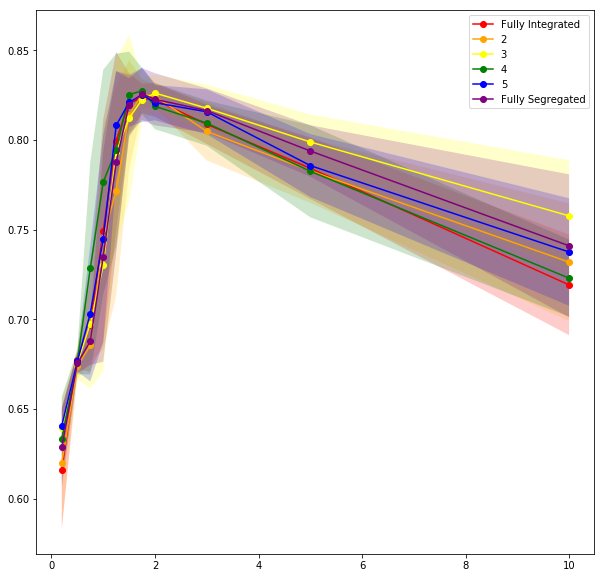

In [147]:
plt.figure(figsize=(10,10))
colors=['red','orange','yellow','green','blue','purple']
names=['Fully Integrated','2','3','4','5','Fully Segregated']
x=onAmp
y=np.mean(np.array(result).reshape(11,6,10),axis=2).T
err=np.std(np.array(result).reshape(11,6,10),axis=2).T
for i in range(len(y)):
    a=plt.plot(x,y[i],'-o',c=colors[i])
    plt.fill_between(x,y[i]-err[i],y[i]+err[i],alpha=0.2,facecolor=colors[i])

plt.legend(names)

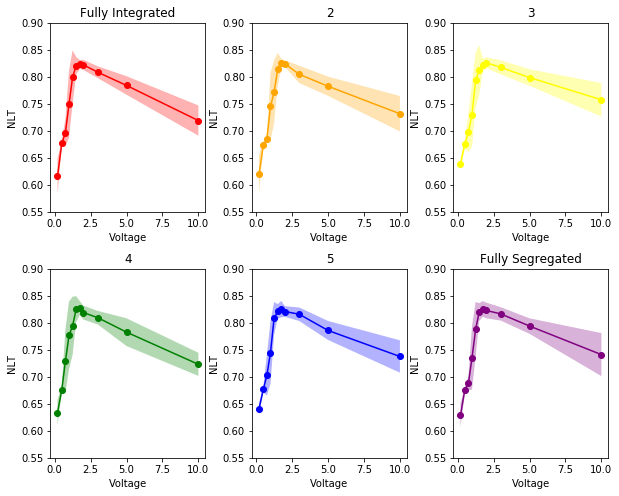

In [149]:
fig,axes=plt.subplots(2,3,figsize=(10,8))
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.3)

a=[]
i=0
for ax in axes.flat:
    a.append(ax.plot(x,y[i],'-o',c=colors[i]))
    ax.fill_between(x,y[i]-err[i],y[i]+err[i],alpha=0.3,facecolor=colors[i])
    ax.set_ylim([0.55,0.9])
    ax.set_title(names[i])
    i=i+1
    ax.set_ylabel('NLT')
    ax.set_xlabel('Voltage')

In [156]:
y.T

array([[0.61613934, 0.61986271, 0.63948835, 0.63352925, 0.64077139,
        0.62866269],
       [0.67707504, 0.67369554, 0.67546655, 0.67626044, 0.67649899,
        0.67541419],
       [0.69678477, 0.68562119, 0.69743732, 0.72848163, 0.70323843,
        0.68778185],
       [0.74943567, 0.74556094, 0.73018115, 0.7765773 , 0.74482202,
        0.7348633 ],
       [0.79969599, 0.77166233, 0.79354361, 0.79441182, 0.80810368,
        0.78755706],
       [0.82079429, 0.81413396, 0.8122848 , 0.82535607, 0.82094574,
        0.81966825],
       [0.82316957, 0.82532757, 0.82248329, 0.8273251 , 0.82525582,
        0.82561778],
       [0.82239483, 0.8244508 , 0.82618013, 0.81880329, 0.82081302,
        0.82269619],
       [0.80874765, 0.80478219, 0.81771906, 0.80941737, 0.81574252,
        0.81640332],
       [0.78426417, 0.78281814, 0.79889267, 0.78257374, 0.78574403,
        0.79388218],
       [0.71919878, 0.73189134, 0.75769043, 0.72297383, 0.73753923,
        0.74099176]])

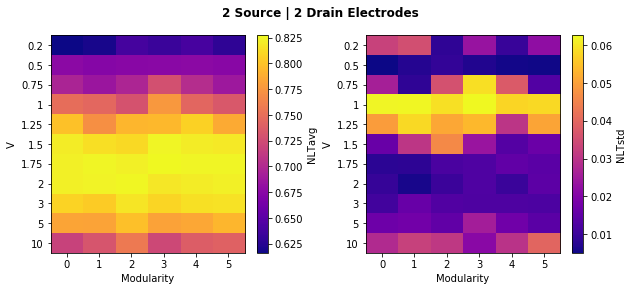

In [161]:
fig,axes=plt.subplots(1,2,figsize=(10,4))
fig.subplots_adjust(wspace=0.3)
fig.suptitle('2 Source | 2 Drain Electrodes',weight='bold')
ax=axes[0]
a=ax.imshow(y.T,aspect='auto',cmap=plt.cm.plasma)
ax.set_xlabel('Modularity')
ax.set_ylabel('V')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(x)

plt.colorbar(a,ax=ax,label='NLTavg')

ax=axes[1]
#Voltage vs Density (std across 10 networks for each combination):
b=ax.imshow(err.T,aspect='auto',cmap=plt.cm.plasma)
ax.set_xlabel('Modularity')
ax.set_ylabel('V')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)

plt.colorbar(b,ax=ax,label='NLTstd')


In [153]:
np.max(result)

0.856522412101222

In [150]:
name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/VoltageSweep_Networks_NWN_9modules_4electrodes_NLT.pkl'
# if (not os.path.isfile(name)): #if we haven't saved the file
print('Saving Max Min Accuracies')
with open(name, 'wb') as f:
    pickle.dump([result], f)   
print('Saved')

Saving Max Min Accuracies
Saved
